# Install dependenices

In [1]:
!pip install -q accelerate
!pip install -q scikit-learn
!pip install -q tqdm
!pip install torchinfo 
!pip install -q pandas
!pip install -q matplotlib 
!pip install huggingface_hub


[notice] A new release of pip is available: 23.0.1 -> 23.1.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.1.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.1.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.1.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.1.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.1.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.1.1
[notice] To update, run: python -m pip install --upgrade pip


# Hyperparameters

In [30]:
import os
file_id = '1w3IQMK3PmXH-Bq6Lt_P8wxGPvr5olrZT'
destination = 'pfam.zip'
n_families_of_interest = 1000
data_dirpath = "pfam"
os.makedirs("models", exist_ok=True)
vocab_size = 32
max_aminoacid_len = 512
batch_size = 128
pin_memory_flag = True

mixed_precision = "fp16" # or "fp32"

In [3]:
import os
import gc
import json
import zipfile
import requests
import numpy as np
import pandas as pd
from functools import partial 
from tqdm.notebook import tqdm 
from collections import Counter
import matplotlib.pyplot as plt
from collections import Counter
from accelerate import Accelerator
from torchinfo import summary
import matplotlib.pyplot as plt
from collections import defaultdict

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import f1_score, accuracy_score, matthews_corrcoef

# Utils

In [4]:
def format_size(value):
  if value >= 1024**3:
    return f"{round(value / 1024**3 , 3)} GB"
  elif value >= 1024**2:
    return f"{round(value / 1024**2 , 3)} MB"
  elif value >= 1024:
    return f"{round(value / 1024 , 3)} KB"
  return f"{value} B"

# Code taken from https://stackoverflow.com/questions/38511444/python-download-files-from-google-drive-using-url
def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)
    params = { 'id' : id, 'confirm' : 1 }
    response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768
    
    pb = tqdm(response.iter_content(CHUNK_SIZE))
    b_total = 0
    with open(destination, "wb") as f:
        for i,chunk in enumerate(pb):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
                b_total += len(chunk)

                if i % 1000 == 0:
                  pb.set_description(f"written : {format_size(b_total)}")
                i += 1
    print("\n")
    print(f"saved all the data to {destination}. total size : {format_size(os.stat(destination).st_size)}")

# Download Dataset

In [5]:
download_file_from_google_drive(file_id, destination)
with zipfile.ZipFile(destination, 'r') as zip_ref:
    zip_ref.extractall(".")
!mv random_split pfam

0it [00:00, ?it/s]



saved all the data to pfam.zip. total size : 493.095 MB
mv: cannot move 'random_split' to 'pfam/random_split': Directory not empty


In [6]:
data_dirpath = "pfam"
print('Available dataset partitions: ', os.listdir(data_dirpath))

Available dataset partitions:  ['train', 'test', 'random_split', 'dev']


# Create a raw dataset

In [7]:
def read_all_shards(partition='dev', data_dir = data_dirpath):
    shards = []
    for fn in os.listdir(os.path.join(data_dir, partition)):
        with open(os.path.join(data_dir, partition, fn)) as f:
            shards.append(pd.read_csv(f, index_col=None))
    
    return pd.concat(shards)

def read_all_data_initial():
  global train, test, dev, all_train_ds_size, all_test_ds_size, all_dev_ds_size

  test = read_all_shards('test')
  dev = read_all_shards('dev')
  train = read_all_shards('train')

  partitions = {'test': test, 'dev': dev, 'train': train}
  for name, df in partitions.items():
      print('Dataset partition "%s" has %d sequences' % (name, len(df)))

  all_train_ds_size = len(train)
  all_test_ds_size = len(test)
  all_dev_ds_size = len(dev)

  train.reset_index(inplace=True, drop=True)
  dev.reset_index(inplace=True, drop=True)
  test.reset_index(inplace=True, drop=True)

read_all_data_initial()

Dataset partition "test" has 126171 sequences
Dataset partition "dev" has 126171 sequences
Dataset partition "train" has 1086741 sequences


# Inspect the data

how many labels : 17929


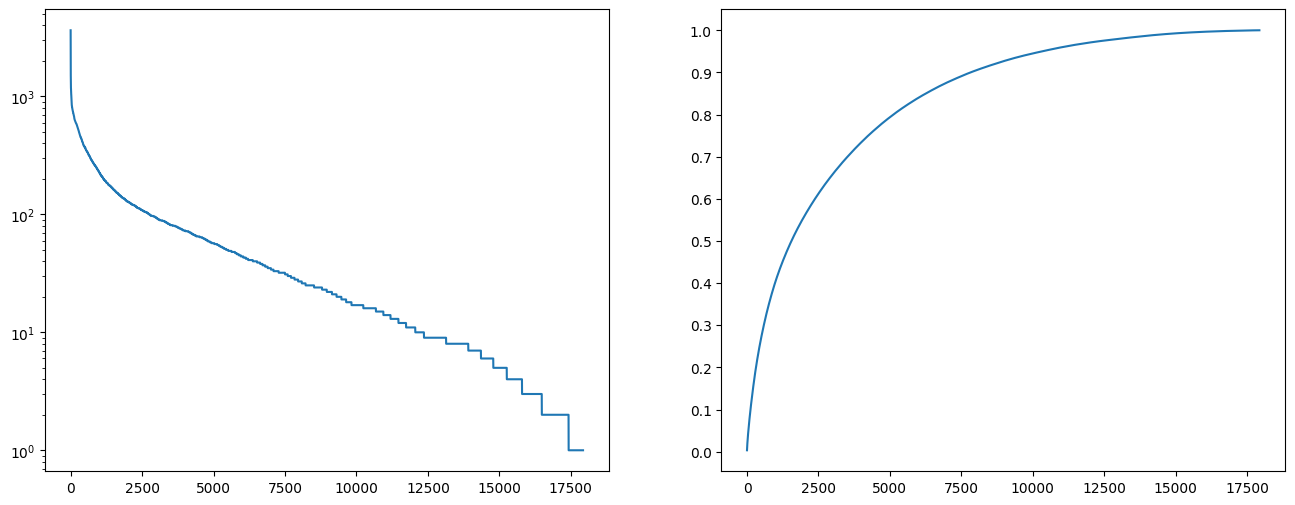

In [8]:
def plot_counts(data):

    counter = Counter(data['family_accession'])
    print(f"how many labels : {len(counter)}")
    
    datasetSize = len(data)
    xs = []
    x_labels = []
    ys = []

    t = 0
    cumulative = []

    for i,(x, y) in  enumerate(counter.most_common()):
        xs.append(i)
        x_labels.append(x)
        ys.append(y)
        t += y / datasetSize
        cumulative.append(t)

    plt.figure(figsize=(16 ,6))
    plt.subplot(1, 2, 1)
    plt.plot(xs, ys)
    plt.yscale("log")

    plt.subplot(1, 2, 2)
    plt.plot(xs, cumulative)
    plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.])
    plt.show()
    return cumulative

cumulative = plot_counts(train)

In [9]:
print(f"{n_families_of_interest} classes is {100 * round( cumulative[n_families_of_interest-1],3)} portion of training data")

1000 classes is 40.400000000000006 portion of training data


# preprocess dataset

how many labels : 991


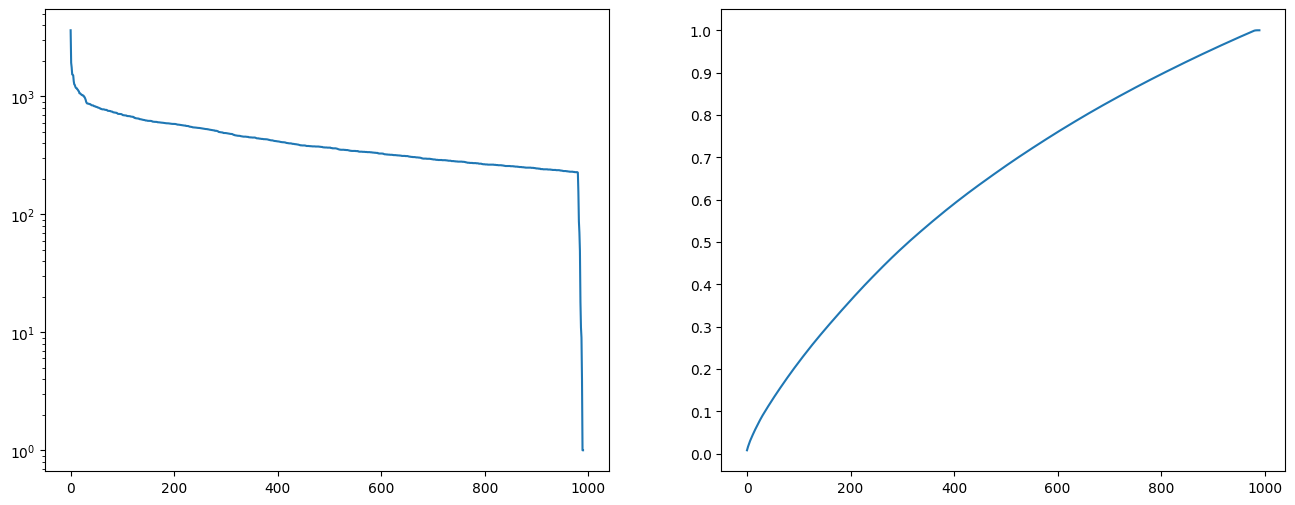

In [10]:
familiesOfInterest = train.family_accession.value_counts()[:n_families_of_interest]

mask = train.family_accession.isin(familiesOfInterest.index.values)
train = train.loc[mask,:]
mask = train["sequence"].str.len() <= max_aminoacid_len
train = train.loc[mask, :]

mask = dev.family_accession.isin(familiesOfInterest.index.values)
dev = dev.loc[mask,:]
mask = dev["sequence"].str.len() <= max_aminoacid_len
dev = dev.loc[mask,:]

mask = test.family_accession.isin(familiesOfInterest.index.values)
test = test.loc[mask,:]
mask = test["sequence"].str.len() <= max_aminoacid_len
test = test.loc[mask,:]

cumulative_split = plot_counts(train)

In [11]:
train_seq = train['sequence']
dev_seq = dev['sequence']
test_seq = test['sequence']
train_sentences = train_seq.apply(lambda seq: " ".join([aa for aa in seq]))
validation_sentences = dev_seq.apply(lambda seq: " ".join([aa for aa in seq]))
test_sentences = test_seq.apply(lambda seq: " ".join([aa for aa in seq]))

train_labels = train['family_accession'].apply(lambda x: x.split('.')[0])
validation_labels = dev['family_accession'].apply(lambda x: x.split('.')[0])
test_labels = test['family_accession'].apply(lambda x: x.split('.')[0])

In [12]:
train_sentences

0          R I G I M T S G G D A P G M N L A I R A V A R ...
4          S L W N I L K K N I G K D L S K V A M P V T L ...
7          F F G D V V G K P G R A A V L E H L P E L R V ...
9          S D V R D M T P D Q L Q D E L L K L K K T Q F ...
10                   S L K F L N F A Q N E F N G S I P E S V
                                 ...                        
1086720    V L D I G C G N G K I T A Q I A E R V P A G A ...
1086724    L S V G L G C N R G T P A K A F E V A V T E L ...
1086729    Q D W V A S V S E P W L M L T P A N G V G S T ...
1086735    D R I V A M S T I S P I I A V V L A L W S L E ...
1086738    E R L M P A F T G L S G S G I A Y V L S F L H ...
Name: sequence, Length: 432209, dtype: object

In [13]:
class Tokenizer(object):
    def __init__(self, vocab_size, padding=512):
        self.idx_to_token = {0: '<pad>', 1:'<s>', 2:'</s>', 3: '<unk>'}
        self.token_to_idx = {k:j for j,k in self.idx_to_token.items()} 
        self.max_size = vocab_size
        self.padding = padding + 2
    
    def __len__(self):
        return len(self.token_to_idx)

    @staticmethod
    def tokenizer(text):
        return [tok.lower().strip() for tok in text.split(' ')]
    
    def build_vocabulary(self, sentences):
        idx = 4
        frequencies = {}
   
        for sentence in tqdm(sentences):
            for word in self.tokenizer(sentence):
                if word not in frequencies.keys():
                    frequencies[word]=1
                else:
                    frequencies[word]+=1
                    
        #limit vocab by removing low freq words
        frequencies = {k:v for k,v in frequencies.items()} 
        
        #limit vocab to the max_size specified
        frequencies = dict(sorted(frequencies.items(), key = lambda x: -x[1])[:self.max_size-idx]) # idx =4 for pad, start, end , unk
            
        #create vocab
        for word in frequencies.keys():
            self.token_to_idx[word] = idx
            self.idx_to_token[idx] = word
            idx+=1
            
    def numericalize(self, text):
        #tokenize text
        tokenized_text = self.tokenizer(text)
        numericalized_text = [self.token_to_idx["<s>"]]
        for token in tokenized_text:
            if token in self.token_to_idx.keys():
                numericalized_text.append(self.token_to_idx[token])
            else: #out-of-vocab words are represented by UNK token index
                numericalized_text.append(self.token_to_idx['<unk>'])
        
        numericalized_text.append(self.token_to_idx['</s>'])
        if self.padding != -1:
          numericalized_text = numericalized_text + [self.token_to_idx["<pad>"]] * (self.padding - len(numericalized_text))

        return np.array(numericalized_text)


In [14]:
%%time
tokenizer = Tokenizer(vocab_size)
tokenizer.build_vocabulary(train_sentences)

  0%|          | 0/432209 [00:00<?, ?it/s]

CPU times: user 21.1 s, sys: 127 ms, total: 21.2 s
Wall time: 21.1 s


In [15]:
%%time
train_sentences = train_sentences.apply(tokenizer.numericalize)
validation_sentences = validation_sentences.apply(tokenizer.numericalize)
test_sentences = test_sentences.apply(tokenizer.numericalize)

CPU times: user 40 s, sys: 729 ms, total: 40.7 s
Wall time: 40.7 s


In [16]:
train_sentences = train_sentences.values
validation_sentences = validation_sentences.values
test_sentences = test_sentences.values

In [17]:
print(Counter([len(v) for v in train_sentences]))
print(Counter([len(v) for v in validation_sentences]))
print(Counter([len(v) for v in test_sentences]))

Counter({514: 432209})
Counter({514: 53471})
Counter({514: 53465})


In [18]:
keys = Counter(train_labels.values).keys()
family_id_to_val = {k : v for v, k in enumerate(keys)}

train_labels = train_labels.map(family_id_to_val).values
validation_labels = validation_labels.map(family_id_to_val).values
test_labels = test_labels.map(family_id_to_val).values

# Pytorch dataset

In [19]:
class Aminoacid_dataset_train(Dataset):
    def __init__(self):
      pass

    def __len__(self):
        return len(train_sentences)

    def __getitem__(self, index):
        return torch.tensor(train_sentences[index]), torch.tensor(train_labels[index]) 

class Aminoacid_dataset_val(Dataset):
    def __init__(self):
      pass

    def __len__(self):
        return len(validation_sentences)

    def __getitem__(self, index):
        return torch.tensor(validation_sentences[index]), torch.tensor(validation_labels[index]) 

class Aminoacid_dataset_test(Dataset):
    def __init__(self):
      pass

    def __len__(self):
        return len(test_sentences)

    def __getitem__(self, index):
        return torch.tensor(test_sentences[index]), torch.tensor(test_labels[index]) 

train_dataset = Aminoacid_dataset_train()
val_dataset = Aminoacid_dataset_val()
test_dataset = Aminoacid_dataset_test()

# for final evaluation
test_dl = DataLoader(test_dataset, batch_size=batch_size, 
                      pin_memory=True, shuffle=False)

# Pytorch training/evaluate functions

In [20]:
def evaluate_model(model, dataset, metrics=[], report_every=100):
  pb = tqdm(dataset)
  model.eval()
  classified_correctly = 0
  len_so_far = 0
  loss_whole = 0
  preds = torch.zeros(len(dataset.dataset))
  true_preds = torch.zeros(len(dataset.dataset))

  for i, (source, targets) in enumerate(pb):
    source = source.to(device)
    targets = targets.to(device)
    output = model(source)
    loss = F.cross_entropy(output, targets)
    pred = torch.argmax(output, dim=1)

    classified_correctly += torch.sum(pred == targets).item()

    # save the predictions for later evalution 
    preds[len_so_far:(len_so_far+targets.shape[0])] = pred
    true_preds[len_so_far:(len_so_far+targets.shape[0])] = targets

    len_so_far += targets.shape[0]
    loss_whole += targets.shape[0] * loss.item()

    if i % report_every == 0:
      pb.set_description(f"Loss : {round(loss.item(), 3)}, Accuracy : {round(classified_correctly / len_so_far, 4)}")

  evaluations = {}
  for metric in metrics:
    if isinstance(metric, partial):
      evaluations[metric.func.__name__] = metric(preds, true_preds)  
    else:
      evaluations[metric.__name__] = metric(preds, true_preds)  
  evaluations["loss"] = loss_whole / len_so_far

  return evaluations

def train_for_epoch(model ,dataset, optimizer, scheduler, metrics=[], report_every=100):
    pb = tqdm(dataset)
    model.train()
    classified_correctly = 0
    len_so_far = 0
    loss_whole = 0

    preds = torch.zeros(len(dataset.dataset))
    true_preds = torch.zeros(len(dataset.dataset))

    for i, (source, targets) in enumerate(pb):

      # move the data to device
      source = source.to(device)
      targets = targets.to(device)
      
      # zero out optimizer before forward pass 
      optimizer.zero_grad()

      # get the predictions
      output = model(source)

      # calculate the loss
      loss = F.cross_entropy(output, targets)
      
      # get the predicted value
      pred = torch.argmax(output, dim=1)

      # update how many classified correctly
      classified_correctly += torch.sum(pred == targets).item()

      # backward pass
      accelerator.backward(loss)

      # do optimizer step and cyclic LR scheduler 
      optimizer.step()
      scheduler.step()

      # save the predictions for later evalution 
      preds[len_so_far:(len_so_far+targets.shape[0])] = pred
      true_preds[len_so_far:(len_so_far+targets.shape[0])] = targets

      # examples so far
      len_so_far += targets.shape[0]

      # whole loss
      loss_whole += targets.shape[0] * loss.item()

      if i % report_every == 0:
        pb.set_description(f"Loss : {round(loss.item(), 3)}, Accuracy : {round(classified_correctly / len_so_far, 4)}")

    optimizer.zero_grad()

    evaluations = {}
    for metric in metrics:
      if isinstance(metric, partial):
        evaluations[metric.func.__name__] = metric(preds, true_preds)  
      else:
        evaluations[metric.__name__] = metric(preds, true_preds)  
          
    evaluations["loss"] = loss_whole / len_so_far

    return evaluations

In [31]:
def train_model_for_n_epochs(model, optimizer_model=torch.optim.Adam, base_lr=1e-4, 
                             max_lr=1e-3, gamma=0.95, epochs=10, plot_results=True,
                             save_to="model.pt"):

  train_dl = DataLoader(train_dataset, batch_size=batch_size, 
                        pin_memory=True, shuffle=True)

  val_dl = DataLoader(val_dataset, batch_size=batch_size, 
                      pin_memory=True, shuffle=False)


  optimizer = optimizer_model(model.parameters())
  scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=base_lr, max_lr=max_lr, cycle_momentum=False, 
                                                step_size_up = 2*len(train_dl), gamma=gamma)

  results = {"train" : [], "val" : []}

  model, optimizer, data = accelerator.prepare(model, optimizer, train_dl)
  report_every = 100

  for epoch in range(epochs):
    print("-"*128)
    print(f"EPOCH : {epoch}")
    train_res = train_for_epoch(model, train_dl, optimizer, scheduler, 
                                report_every=report_every, 
                                metrics=[partial(f1_score, average="micro"), accuracy_score, matthews_corrcoef])
    
    valid_res = evaluate_model(model, val_dl, 
                              report_every=report_every, 
                              metrics=[partial(f1_score, average="micro"), accuracy_score, matthews_corrcoef])
    
    results["train"].append(train_res)
    results["val"].append(valid_res)

  # save the model by unwrapping from FP16, and then wrap ( slow ? TODO )
  accelerator.save(accelerator.unwrap_model(model, keep_fp32_wrapper=False), save_to)
 
  if plot_results:
    plot_results_data(results)
  return results


def plot_results_data(results):
  fig, axs = plt.subplots(3, figsize=(16, 9), sharex=True)
  vs = defaultdict(list)

  for v in results["train"]:
    for k, v in v.items():
      vs["training_"+k].append(v)

  for v in results["val"]:
    for k, v in v.items():
      vs["validation_"+k].append(v)

  axs[0].plot(vs["training_loss"], label="Training loss")
  axs[0].plot(vs["validation_loss"], label="Training loss")
  axs[0].legend()
  axs[0].set_title("Training/Validation Loss")

  vs.pop("training_loss")
  vs.pop("validation_loss")

  for k, v in vs.items():
    if k.startswith("training"):
      axs[1].plot(v, label=k)
  axs[1].legend()
  axs[1].set_title("training metrics")

  for k, v in vs.items():
    if k.startswith("validation"):
      axs[2].plot(v, label=k)

  axs[2].legend()
  axs[2].set_title("validation metrics")

  plt.show()

# ProtCNN

## Architecture

In [32]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, dil, filters, ks=3):
        super(ResidualBlock, self).__init__()
        self.bn1 = nn.BatchNorm1d(in_channels)
        self.relu1 = nn.ReLU()
        self.conv1 = nn.Conv1d(in_channels, filters, ks, padding="same", dilation=dil)
        
        self.bn2 = nn.BatchNorm1d(filters)
        self.relu2 = nn.ReLU()
        self.conv2 = nn.Conv1d(filters, filters, ks, padding="same")
        
    def forward(self, x):
        shortcut = x
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv1(x)
        
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.conv2(x)
        
        x += shortcut
        return x


class ProtCNN(nn.Module):
    def __init__(self, numclass, inp_size, vocab_size, residuals_ks=3, residuals_filters=64):
        super(ProtCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, vocab_size, padding_idx=None)
        self.embedding.weight.data.copy_(torch.eye(vocab_size))
        self.embedding.weight.requires_grad = False
        self.conv1 = nn.Conv1d(inp_size, 64, 8, padding="same")
        
        self.res_block1 = ResidualBlock(64, 1, residuals_filters, ks=residuals_ks)
        self.res_block2 = ResidualBlock(residuals_filters, 2, residuals_filters, ks=residuals_ks)
        
        self.conv2 = nn.Conv1d(32, 64, 3, padding=1)
        
        self.res_block3 = ResidualBlock(64, 1, residuals_filters, ks=residuals_ks)
        self.res_block4 = ResidualBlock(residuals_filters, 2, residuals_filters, ks=residuals_ks)
        
        self.conv3 = nn.Conv2d(1, 32, (4, 4), padding="same")
        self.conv4 = nn.Conv2d(32, 8, (8, 8), padding="same")
        self.maxpool = nn.MaxPool2d((64, 64))
        self.fc = nn.Linear(8, numclass+1)

    def forward(self, x):
        x = self.embedding(x)
        # x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.res_block1(x)
        x = self.res_block2(x)
        x = x.permute(0, 2, 1)
        x = self.conv2(x)
        x = self.res_block3(x)
        x = self.res_block4(x)
        x = x.unsqueeze(1)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        #x = F.softmax(x, dim=1)
        return x

## Experiment 1

Layer (type:depth-idx)                   Output Shape              Param #
ProtCNN                                  [1, 1001]                 --
├─Embedding: 1-1                         [1, 514, 32]              (1,024)
├─Conv1d: 1-2                            [1, 64, 32]               263,232
├─ResidualBlock: 1-3                     [1, 64, 32]               --
│    └─BatchNorm1d: 2-1                  [1, 64, 32]               128
│    └─ReLU: 2-2                         [1, 64, 32]               --
│    └─Conv1d: 2-3                       [1, 64, 32]               12,352
│    └─BatchNorm1d: 2-4                  [1, 64, 32]               128
│    └─ReLU: 2-5                         [1, 64, 32]               --
│    └─Conv1d: 2-6                       [1, 64, 32]               12,352
├─ResidualBlock: 1-4                     [1, 64, 32]               --
│    └─BatchNorm1d: 2-7                  [1, 64, 32]               128
│    └─ReLU: 2-8                         [1, 64, 32]            

/usr/local/lib/python3.10/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.10/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 1


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 2


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 3


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 4


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 5


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 6


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 7


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 8


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 9


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 10


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 11


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 12


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 13


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 14


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 15


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 16


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 17


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 18


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 19


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 20


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 21


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 22


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 23


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 24


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

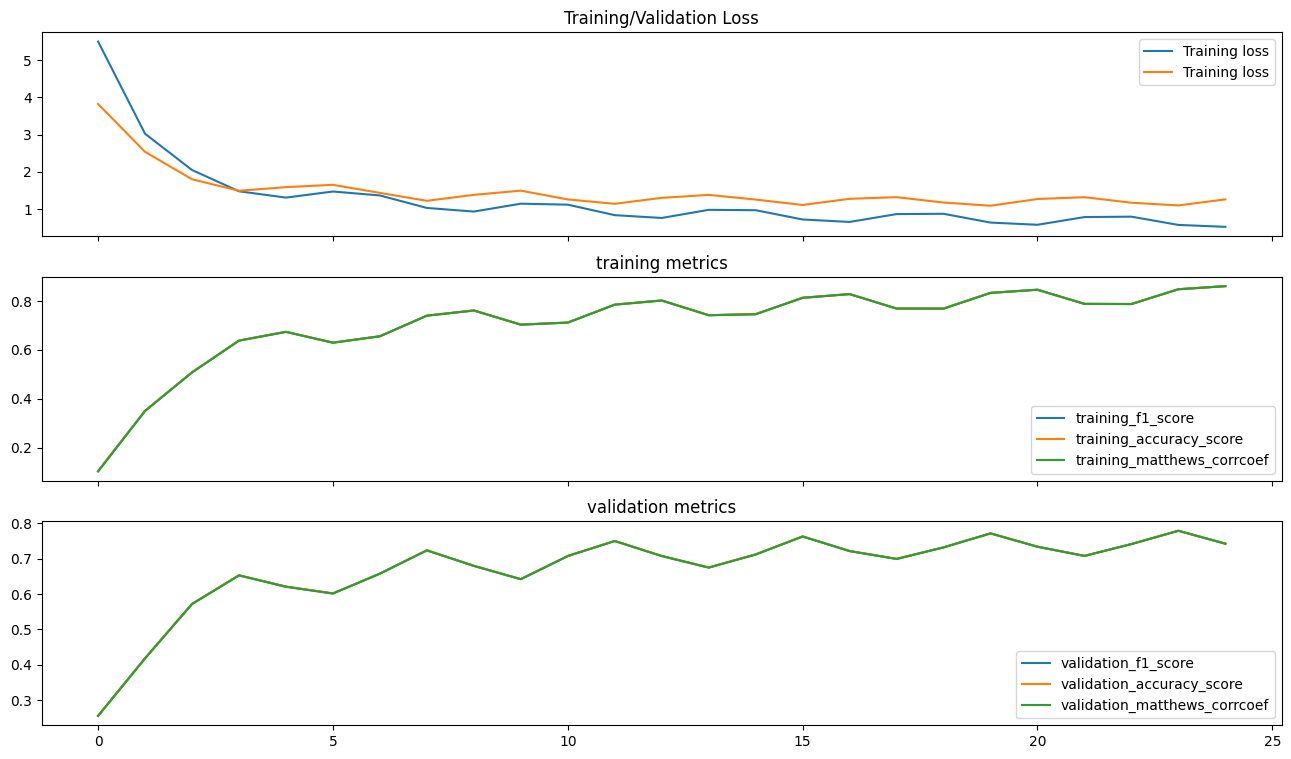

  0%|          | 0/1671 [00:00<?, ?it/s]

{'f1_score': 0.7404470214158796,
 'accuracy_score': 0.7404470214158796,
 'matthews_corrcoef': 0.7401327036092678,
 'loss': 1.262027320122235}

In [36]:
model_name = os.path.join("models","protCNN1.pt")
epochs = 25

accelerator = Accelerator(mixed_precision=mixed_precision)
device = accelerator.device
model = ProtCNN(n_families_of_interest, max_aminoacid_len + 2, 32)
model = model.to(device)
print(summary(model, input_data=torch.zeros((1, max_aminoacid_len + 2)).long().to(device)))

results = train_model_for_n_epochs(model, epochs=epochs, save_to=model_name, base_lr=1e-4,  max_lr=1e-3, gamma=0.9)
evaluate_model(torch.load(model_name), test_dl, metrics=[partial(f1_score, average="micro"), accuracy_score, matthews_corrcoef])

## Experiment 2

Layer (type:depth-idx)                   Output Shape              Param #
ProtCNN                                  [1, 1001]                 --
├─Embedding: 1-1                         [1, 514, 32]              (1,024)
├─Conv1d: 1-2                            [1, 64, 32]               263,232
├─ResidualBlock: 1-3                     [1, 64, 32]               --
│    └─BatchNorm1d: 2-1                  [1, 64, 32]               128
│    └─ReLU: 2-2                         [1, 64, 32]               --
│    └─Conv1d: 2-3                       [1, 64, 32]               20,544
│    └─BatchNorm1d: 2-4                  [1, 64, 32]               128
│    └─ReLU: 2-5                         [1, 64, 32]               --
│    └─Conv1d: 2-6                       [1, 64, 32]               20,544
├─ResidualBlock: 1-4                     [1, 64, 32]               --
│    └─BatchNorm1d: 2-7                  [1, 64, 32]               128
│    └─ReLU: 2-8                         [1, 64, 32]            

  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 1


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 2


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 3


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 4


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 5


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 6


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 7


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 8


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 9


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 10


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 11


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 12


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 13


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 14


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 15


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 16


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 17


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 18


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 19


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 20


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 21


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 22


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 23


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 24


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

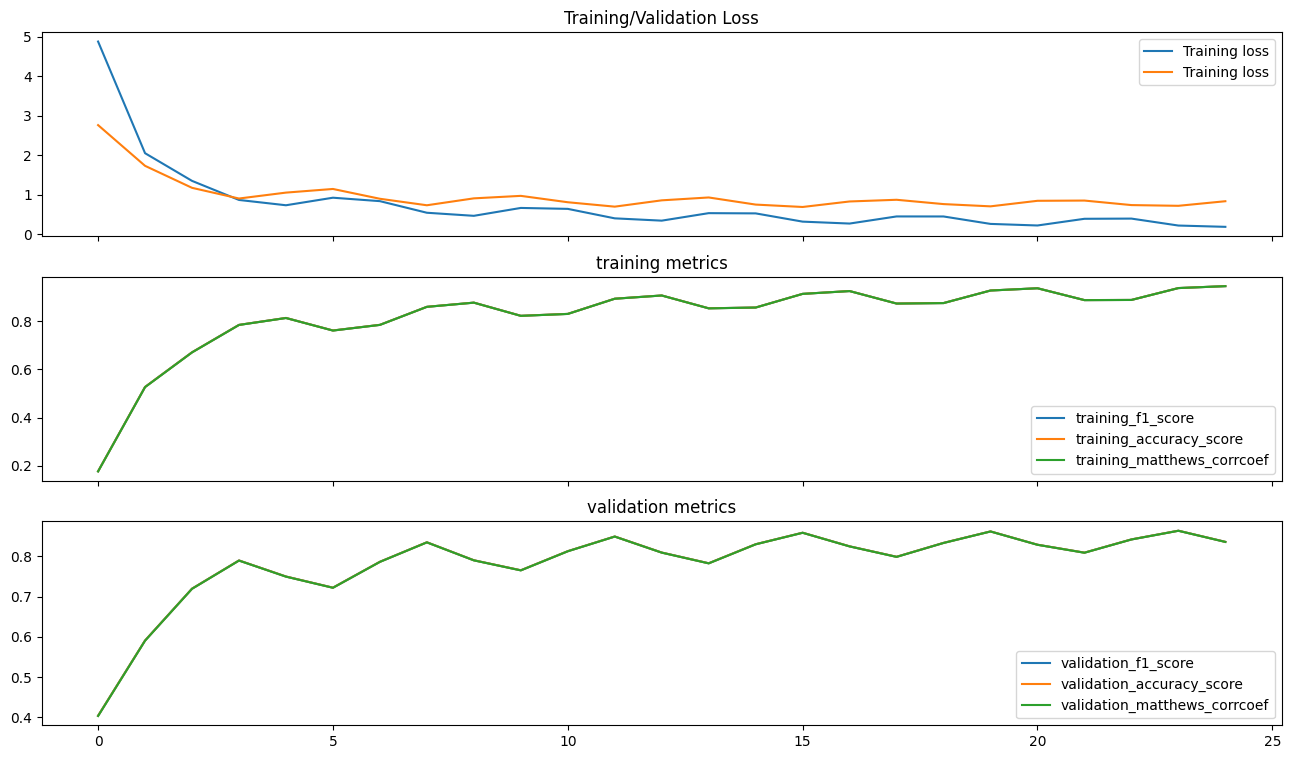

  0%|          | 0/1671 [00:00<?, ?it/s]

{'f1_score': 0.8324698400822969,
 'accuracy_score': 0.8324698400822969,
 'matthews_corrcoef': 0.8322635091973672,
 'loss': 0.8483660991300226}

In [38]:
model_name = os.path.join("models","protCNN1_ks=5.pt")
epochs = 25

accelerator = Accelerator(mixed_precision=mixed_precision)
device = accelerator.device
model = ProtCNN(n_families_of_interest, max_aminoacid_len + 2, 32, residuals_ks=5, residuals_filters=64)
model = model.to(device)
print(summary(model, input_data=torch.zeros((1, max_aminoacid_len + 2)).long().to(device)))

results = train_model_for_n_epochs(model, epochs=epochs, save_to=model_name, base_lr=1e-4,  max_lr=1e-3, gamma=0.85)
evaluate_model(torch.load(model_name), test_dl, metrics=[partial(f1_score, average="micro"), accuracy_score, matthews_corrcoef])

## Experiment 3

Layer (type:depth-idx)                   Output Shape              Param #
ProtCNN                                  [1, 1001]                 --
├─Embedding: 1-1                         [1, 514, 32]              (1,024)
├─Conv1d: 1-2                            [1, 64, 32]               263,232
├─ResidualBlock: 1-3                     [1, 64, 32]               --
│    └─BatchNorm1d: 2-1                  [1, 64, 32]               128
│    └─ReLU: 2-2                         [1, 64, 32]               --
│    └─Conv1d: 2-3                       [1, 64, 32]               28,736
│    └─BatchNorm1d: 2-4                  [1, 64, 32]               128
│    └─ReLU: 2-5                         [1, 64, 32]               --
│    └─Conv1d: 2-6                       [1, 64, 32]               28,736
├─ResidualBlock: 1-4                     [1, 64, 32]               --
│    └─BatchNorm1d: 2-7                  [1, 64, 32]               128
│    └─ReLU: 2-8                         [1, 64, 32]            

/usr/local/lib/python3.10/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.10/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 1


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 2


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 3


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 4


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 5


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 6


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 7


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 8


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 9


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 10


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 11


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 12


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 13


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 14


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 15


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 16


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 17


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 18


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 19


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 20


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 21


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 22


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 23


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 24


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

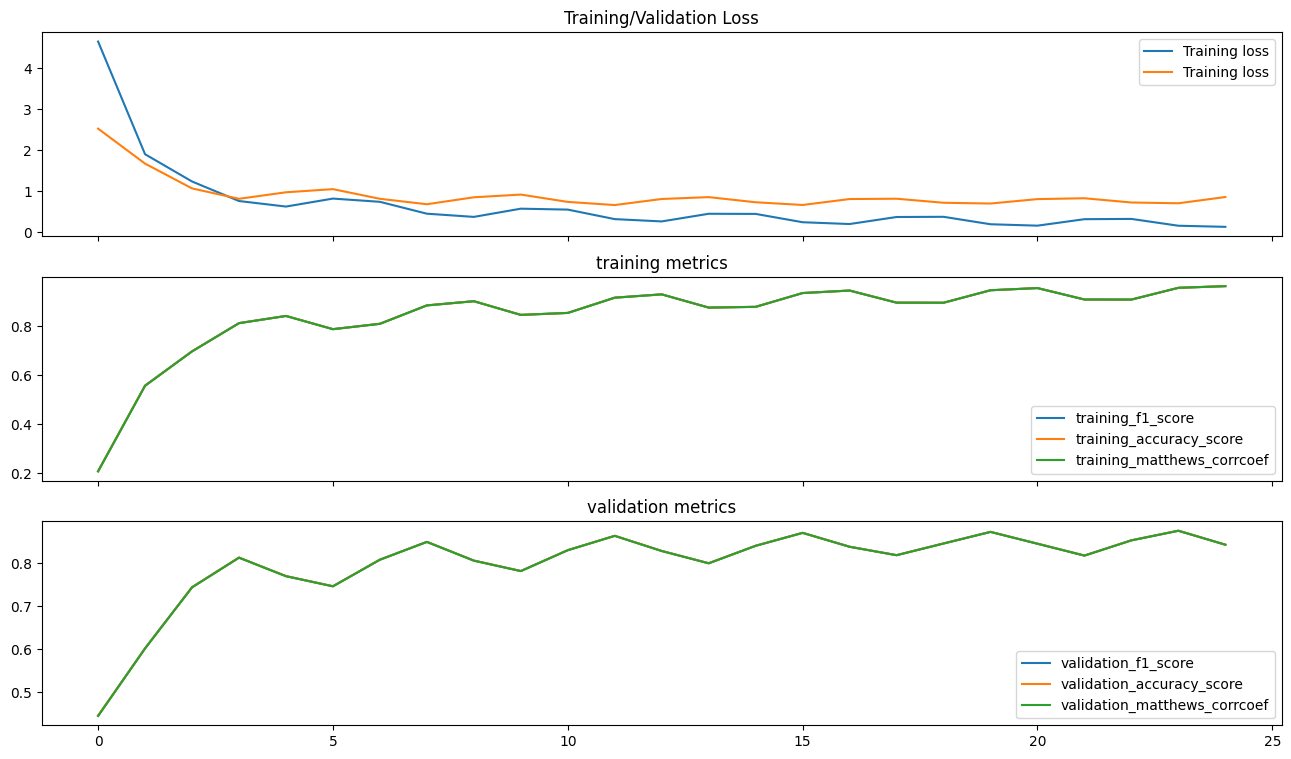

  0%|          | 0/1671 [00:00<?, ?it/s]

{'f1_score': 0.8425512017207519,
 'accuracy_score': 0.8425512017207519,
 'matthews_corrcoef': 0.8423562201964511,
 'loss': 0.8605104190659659}

In [39]:
model_name = os.path.join("models","protCNN1_ks=7.pt")
epochs = 25

accelerator = Accelerator(mixed_precision=mixed_precision)
device = accelerator.device
model = ProtCNN(n_families_of_interest, max_aminoacid_len + 2, 32, residuals_ks=7, residuals_filters=64)
model = model.to(device)
print(summary(model, input_data=torch.zeros((1, max_aminoacid_len + 2)).long().to(device)))

results = train_model_for_n_epochs(model, epochs=epochs, save_to=model_name, base_lr=1e-4,  max_lr=1e-3, gamma=0.85)
evaluate_model(torch.load(model_name), test_dl, metrics=[partial(f1_score, average="micro"), accuracy_score, matthews_corrcoef])

## Experiment 4

In [81]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, dil, filters, ks=3):
        super(ResidualBlock, self).__init__()
        self.bn1 = nn.BatchNorm1d(in_channels)
        self.relu1 = nn.ReLU()
        self.conv1 = nn.Conv1d(in_channels, filters, ks, padding="same", dilation=dil)
        
        self.bn2 = nn.BatchNorm1d(filters)
        self.relu2 = nn.ReLU()
        self.conv2 = nn.Conv1d(filters, filters, ks, padding="same")
        
    def forward(self, x):
        shortcut = x
        #print(x.shape)
        x = self.bn1(x)
        #print(x.shape)
        x = self.relu1(x)
        #print(x.shape)
        x = self.conv1(x)
        #print(x.shape)
        
        x = self.bn2(x)
        #print(x.shape)
        x = self.relu2(x)
        #print(x.shape)
        x = self.conv2(x)
        
        #print(x.shape, shortcut.shape)
        x += shortcut
        return x


class ProtCNN2(nn.Module):
    def __init__(self, numclass, inp_size, vocab_size, residuals_ks1=3, residuals_ks2=3, residuals_filters=64):
        super(ProtCNN2, self).__init__()
        self.embedding = nn.Embedding(vocab_size, vocab_size, padding_idx=None)
        self.embedding.weight.data.copy_(torch.eye(vocab_size))
        self.embedding.weight.requires_grad = False
        self.conv1 = nn.Conv1d(inp_size, residuals_filters, 8, padding="same")
        
        self.res_block1 = ResidualBlock(residuals_filters, 1, residuals_filters, ks=residuals_ks1)
        self.res_block2 = ResidualBlock(residuals_filters, 1, residuals_filters, ks=residuals_ks1)
        self.res_block3 = ResidualBlock(residuals_filters, 2, residuals_filters, ks=residuals_ks1)
        
        self.conv2 = nn.Conv1d(32, residuals_filters, 3, padding=1)
        
        self.res_block4 = ResidualBlock(residuals_filters, 1, residuals_filters, ks=residuals_ks2)
        self.res_block5 = ResidualBlock(residuals_filters, 1, residuals_filters, ks=residuals_ks2)
        self.res_block6 = ResidualBlock(residuals_filters, 2, residuals_filters, ks=residuals_ks2)
        
        self.conv3 = nn.Conv2d(1, 32, (4, 4), padding="same")
        self.conv4 = nn.Conv2d(32, 8, (8, 8), padding="same")
        self.maxpool = nn.MaxPool2d((residuals_filters, residuals_filters))
        self.fc = nn.Linear(8, numclass+1)

    def forward(self, x):
        x = self.embedding(x)
        # x = x.permute(0, 2, 1)
        #print(x.shape)
        x = self.conv1(x)
        #print(x.shape)
        x = self.res_block1(x)
        #print(x.shape)
        x = self.res_block2(x)
        x = self.res_block3(x)
        x = x.permute(0, 2, 1)
        x = self.conv2(x)
        x = self.res_block4(x)
        x = self.res_block5(x)
        x = self.res_block6(x)
        x = x.unsqueeze(1)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        #print(x.shape)
        x = F.relu(x)
        x = self.maxpool(x)
        #print(x.shape)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        #x = F.softmax(x, dim=1)
        return x

Layer (type:depth-idx)                   Output Shape              Param #
ProtCNN2                                 [1, 1001]                 --
├─Embedding: 1-1                         [1, 514, 32]              (1,024)
├─Conv1d: 1-2                            [1, 128, 32]              526,464
├─ResidualBlock: 1-3                     [1, 128, 32]              --
│    └─BatchNorm1d: 2-1                  [1, 128, 32]              256
│    └─ReLU: 2-2                         [1, 128, 32]              --
│    └─Conv1d: 2-3                       [1, 128, 32]              82,048
│    └─BatchNorm1d: 2-4                  [1, 128, 32]              256
│    └─ReLU: 2-5                         [1, 128, 32]              --
│    └─Conv1d: 2-6                       [1, 128, 32]              82,048
├─ResidualBlock: 1-4                     [1, 128, 32]              --
│    └─BatchNorm1d: 2-7                  [1, 128, 32]              256
│    └─ReLU: 2-8                         [1, 128, 32]           

  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 1


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 2


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 3


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 4


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 5


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 6


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 7


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 8


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 9


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 10


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 11


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 12


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 13


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 14


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 15


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 16


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 17


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 18


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------------------
EPOCH : 19


  0%|          | 0/3377 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

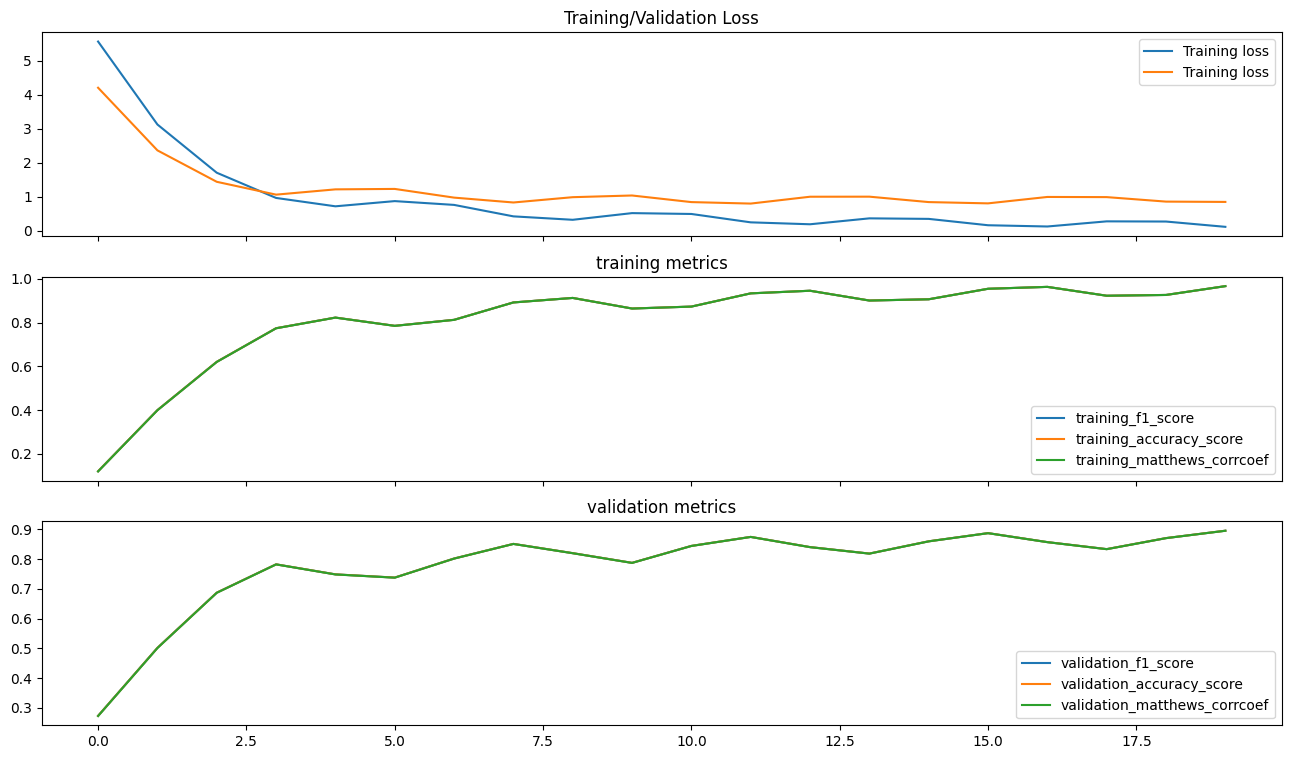

  0%|          | 0/1671 [00:00<?, ?it/s]

{'f1_score': 0.8961937716262975,
 'accuracy_score': 0.8961937716262975,
 'matthews_corrcoef': 0.8960626588304276,
 'loss': 0.8254684574815658}

In [82]:
model_name = os.path.join("models","ProtCNN2_ks=5_3residuals.pt")
epochs = 20

accelerator = Accelerator(mixed_precision=mixed_precision)
device = accelerator.device
model = ProtCNN2(n_families_of_interest, max_aminoacid_len + 2, 32, residuals_ks1=5, residuals_ks2=5, residuals_filters=128)
model = model.to(device)
print(summary(model, input_data=torch.zeros((1, max_aminoacid_len + 2)).long().to(device)))

results = train_model_for_n_epochs(model, epochs=epochs, optimizer_model=torch.optim.Adam, save_to=model_name, gamma=0.9,
                                   base_lr=1e-4, max_lr=5e-4,)

model_name = os.path.join("models","ProtCNN2_ks=5_3residuals.pt")
evaluate_model(torch.load(model_name), test_dl, metrics=[partial(f1_score, average="micro"), accuracy_score, matthews_corrcoef])

In [84]:
evaluate_model(torch.load(os.path.join("models", "protCNN1.pt")), test_dl, metrics=[partial(f1_score, average="micro"), accuracy_score, matthews_corrcoef])

  0%|          | 0/1671 [00:00<?, ?it/s]

{'f1_score': 0.7404470214158796,
 'accuracy_score': 0.7404470214158796,
 'matthews_corrcoef': 0.7401327036092678,
 'loss': 1.262027320122235}

In [ ]:
evaluate_model(torch.load(os.path.join("models", "protCNN1.pt")), test_dl, metrics=[partial(f1_score, average="micro"), accuracy_score, matthews_corrcoef])

In [85]:
model_name = os.path.join("models","ProtCNN2_ks=5_3residuals.pt")
evaluate_model(torch.load(model_name), test_dl, metrics=[partial(f1_score, average="micro"), accuracy_score, matthews_corrcoef])

  0%|          | 0/1671 [00:00<?, ?it/s]

{'f1_score': 0.8961937716262975,
 'accuracy_score': 0.8961937716262975,
 'matthews_corrcoef': 0.8960626588304276,
 'loss': 0.8254684574815658}

In [86]:
torch.save(model.state_dict(), os.path.join("models","state_dict_ProtCNN2_ks=5_3residuals.pt"))

In [87]:
eval_model = ProtCNN2(n_families_of_interest, max_aminoacid_len + 2, 32, residuals_ks1=5, residuals_ks2=5, residuals_filters=128)
eval_model = eval_model.to("cpu")
model.load_state_dict(torch.load(os.path.join("models", "state_dict_ProtCNN2_ks=5_3residuals.pt")))
evaluate_model(model, test_dl, metrics=[partial(f1_score, average="micro"), accuracy_score, matthews_corrcoef])

  0%|          | 0/1671 [00:00<?, ?it/s]

{'f1_score': 0.8961937716262975,
 'accuracy_score': 0.8961937716262975,
 'matthews_corrcoef': 0.8960626588304276,
 'loss': 0.8254684574815658}